In [4]:
!pip install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: n

✅ Opacus détecté via RDPAccountant (1.5.4+ API)
Taille TRAIN complet: 5232
Taille TEST: 624
Classes: ['NORMAL', 'PNEUMONIA']
Déséquilibre des classes: [1349 3883]
Ratio: 2.88:1 (PNEUMONIA:NORMAL)
Partitionnement des données sur 20 clients...
Distribution des classes: [1349 3883]
✅ Partitionnement réussi:
   Taille min: 56, max: 706, moyenne: 261.6
   Client 0: 233 échantillons, distribution: [ 47 186]
   Client 1: 530 échantillons, distribution: [ 67 463]
   Client 2: 358 échantillons, distribution: [ 61 297]

🎯 Configuration finale:
   Clients actifs: 20
   Clients par round: 20
✅ CNN Simple créé avec succès
📊 Paramètres entraînables: 5,831,298/5,831,298 (100.0%)
✅ Test forward pass réussi: input torch.Size([2, 3, 128, 128]) -> output torch.Size([2, 2])
Recherche du multiplicateur de bruit optimal pour ε<10.0...
  noise_mult=4.0 -> ε=14.13
  noise_mult=4.5 -> ε=12.21
  noise_mult=5.0 -> ε=10.73
  noise_mult=5.5 -> ε=9.55
✅ Multiplicateur de bruit optimal trouvé: 5.5 (ε=9.55)
🔒 Paramèt

ValueError: 'orange-D' is not a valid format string (unrecognized character 'a')

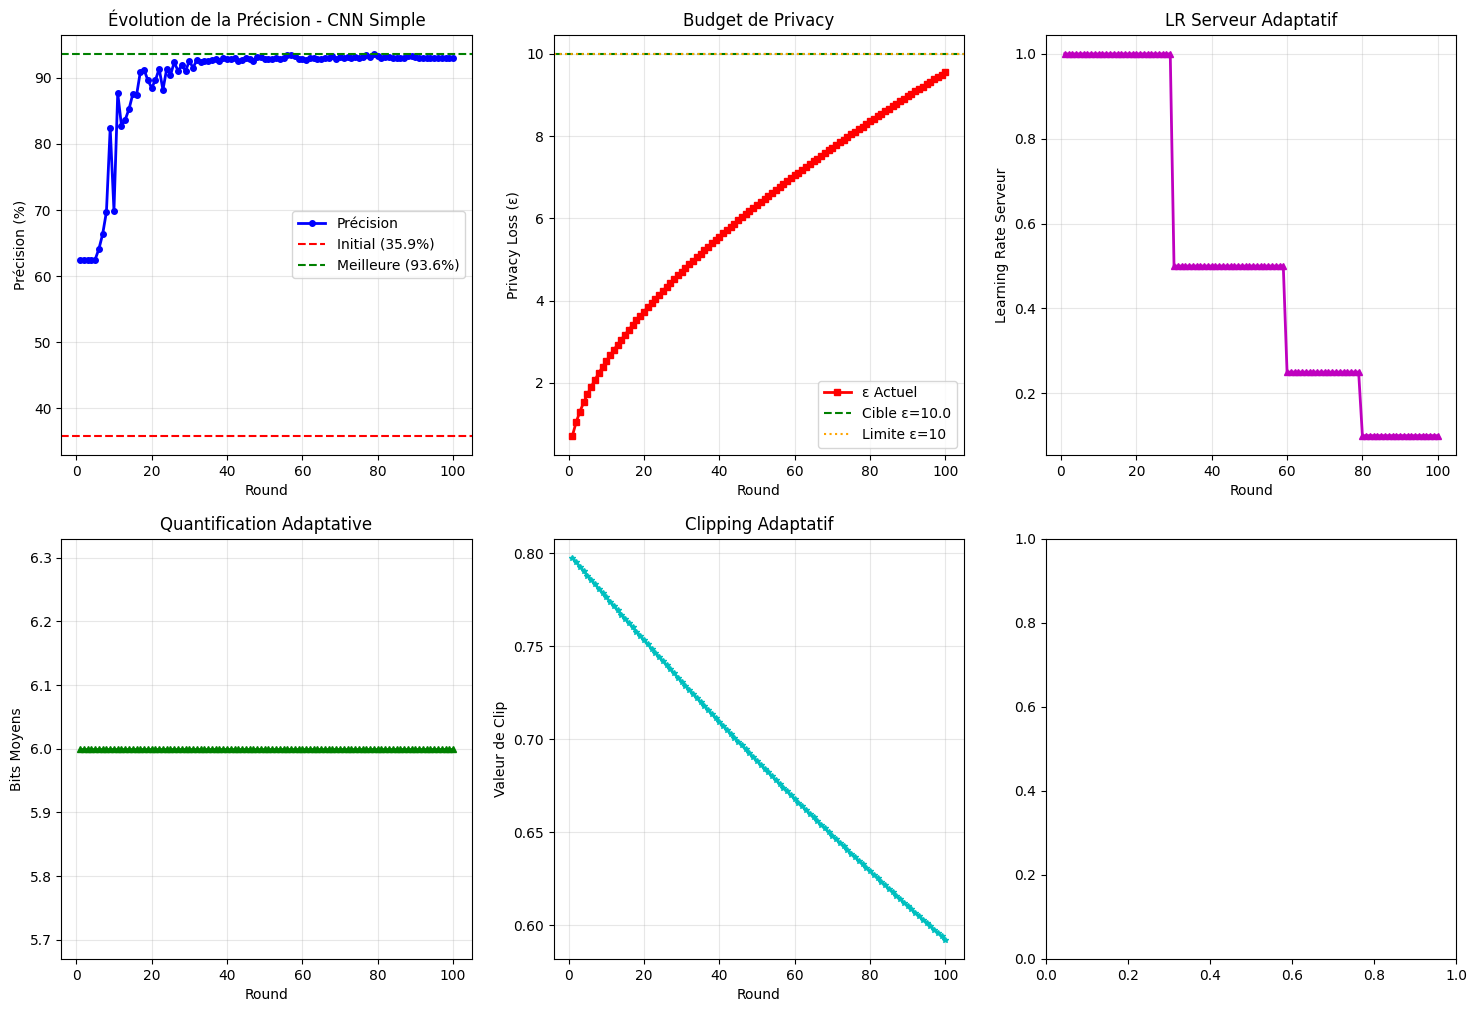

In [5]:
# ==============================================================
# ANCCO-FL - VERSION AVEC EPSILON < 10 GARANTI ET CNN SIMPLE
# ==============================================================

import os, copy, math, random, time, sys
from typing import Dict, List, Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# ==============================================================
# ✅ Opacus import
# ==============================================================
USE_OPACUS = True

try:
    from opacus.accountants import RDPAccountant
    print("✅ Opacus détecté via RDPAccountant (1.5.4+ API)")
except Exception as e:
    print(f"⚠️ Opacus import échoué: {e}")
    USE_OPACUS = False

# ==============================================================
# CONFIGURATION POUR EPSILON < 10
# ==============================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "/kaggle/input/labeled-chest-xray-images/chest_xray"
BATCH_SIZE = 16
GLOBAL_EPOCHS = 100
num_clients = 20
local_epochs = 2
INITIAL_CLIENT_LR = 0.01
seed_global = 42
torch.manual_seed(seed_global)
np.random.seed(seed_global)
random.seed(seed_global)

# Paramètres ANCCO-FL AVEC PRIVACY RENFORCÉE
max_bits = 8
min_bits = 4
entropy_scaling = 0.05
clip_initial = 0.8  # RÉDUIT pour diminuer la sensibilité
clip_decay = 0.997
INITIAL_SERVER_LR = 1.0
sigma_common = 0.8  # AUGMENTÉ
sigma_individual = 4.0  # FORTEMENT AUGMENTÉ pour epsilon < 10
TARGET_EPS = 10.0
TARGET_DELTA = 1e-5
CLIENTS_PER_ROUND = 20
ENABLE_QUANT = ENABLE_NOISE = ENABLE_CANCELLATION = True
ENABLE_PRIVACY_ACCOUNTING = USE_OPACUS and (TARGET_EPS is not None)
DIRICHLET_ALPHA = 1.0
eps = 1e-12

# ==============================================================
# FONCTIONS POUR LEARNING RATE ADAPTATIF SERVEUR
# ==============================================================
def adaptive_server_learning_rate(round_num, total_rounds=GLOBAL_EPOCHS):
    """
    Learning rate adaptatif pour le serveur
    Decay exponentiel avec stabilisation en fin d'entraînement
    """
    if round_num < total_rounds * 0.3:  # Première phase: LR élevé
        return INITIAL_SERVER_LR
    elif round_num < total_rounds * 0.6:  # Deuxième phase: LR moyen
        return INITIAL_SERVER_LR * 0.5
    elif round_num < total_rounds * 0.8:  # Troisième phase: LR bas
        return INITIAL_SERVER_LR * 0.25
    else:  # Dernière phase: LR très bas pour stabilisation
        return INITIAL_SERVER_LR * 0.1

# ==============================================================
# FONCTIONS OPTIMISÉES POUR PRIVACY
# ==============================================================
def find_optimal_noise_multiplier(target_eps, target_delta, max_steps):
    """Trouve le bruit optimal pour garantir epsilon < 10"""
    if not USE_OPACUS:
        return 5.0  # Valeur conservative par défaut
    
    print(f"Recherche du multiplicateur de bruit optimal pour ε<{target_eps}...")
    
    # Test de valeurs élevées pour garantir epsilon < 10
    for noise_mult in [4.0, 4.5, 5.0, 5.5, 6.0]:
        try:
            accountant = RDPAccountant()
            sample_rate = CLIENTS_PER_ROUND / num_clients
            
            for _ in range(max_steps):
                accountant.step(noise_multiplier=noise_mult, sample_rate=sample_rate)
            
            eps = accountant.get_epsilon(target_delta)
            print(f"  noise_mult={noise_mult:.1f} -> ε={eps:.2f}")
            
            if eps <= target_eps:
                print(f"✅ Multiplicateur de bruit optimal trouvé: {noise_mult:.1f} (ε={eps:.2f})")
                return noise_mult
                
        except Exception as e:
            continue
    
    # Si aucune valeur ne respecte la contrainte, prendre la plus conservative
    print("⚠️ Utilisation du multiplicateur de bruit conservateur: 6.0")
    return 6.0

def compute_epsilon_with_limit(steps, target_delta, max_epsilon=10.0):
    """Calcule epsilon et vérifie s'il dépasse la limite"""
    if not USE_OPACUS:
        return None, False
    
    try:
        accountant = RDPAccountant()
        sample_rate = CLIENTS_PER_ROUND / num_clients
        noise_multiplier = sigma_individual / max(clip_initial, 1e-6)
        
        for _ in range(steps):
            accountant.step(noise_multiplier=noise_multiplier, sample_rate=sample_rate)
        
        epsilon = accountant.get_epsilon(target_delta)
        exceeded = epsilon > max_epsilon
        return epsilon, exceeded
    except Exception as e:
        return None, False

# ==============================================================
# CHARGEMENT DES DONNÉES AVEC AUGMENTATION AMÉLIORÉE
# ==============================================================
# Réduction de la taille d'image pour CNN simple
IMG_SIZE = 128

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_tf)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=test_tf)
print(f"Taille TRAIN complet: {len(train_dataset)}")
print(f"Taille TEST: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

# Analyser le déséquilibre des classes
train_labels = [label for _, label in train_dataset.samples]
class_counts = np.bincount(train_labels)
print(f"Déséquilibre des classes: {class_counts}")
print(f"Ratio: {class_counts[1]/class_counts[0]:.2f}:1 (PNEUMONIA:NORMAL)")

# ==============================================================
# PARTITIONNEMENT AVEC ÉQUILIBRAGE (Dirichlet)
# ==============================================================
def make_balanced_dirichlet_partitions(dataset, num_clients, alpha=1.0, seed=42, min_samples_per_client=30):
    np.random.seed(seed)
    labels = np.array([y for (_, y) in dataset.samples])
    num_classes = len(np.unique(labels))
    
    print(f"Partitionnement des données sur {num_clients} clients...")
    print(f"Distribution des classes: {np.bincount(labels)}")
    
    client_indices = [[] for _ in range(num_clients)]
    
    for class_id in range(num_classes):
        class_indices = np.where(labels == class_id)[0]
        np.random.shuffle(class_indices)
        
        if len(class_indices) == 0:
            continue
            
        proportions = np.random.dirichlet([alpha] * num_clients)
        min_prop = min_samples_per_client / len(class_indices)
        proportions = np.maximum(proportions, min_prop)
        proportions = proportions / proportions.sum()
        
        counts = (proportions * len(class_indices)).astype(int)
        total_assigned = counts.sum()
        
        while total_assigned < len(class_indices):
            deficit = len(class_indices) - total_assigned
            sorted_indices = np.argsort(proportions)[::-1]
            for i in range(min(deficit, num_clients)):
                counts[sorted_indices[i]] += 1
            total_assigned = counts.sum()
            
        while total_assigned > len(class_indices):
            counts[np.argmax(counts)] -= 1
            total_assigned = counts.sum()
        
        start_idx = 0
        for client_id in range(num_clients):
            end_idx = start_idx + counts[client_id]
            client_indices[client_id].extend(class_indices[start_idx:end_idx])
            start_idx = end_idx
    
    # Vérification et équilibrage minimal
    for client_id in range(num_clients):
        if len(client_indices[client_id]) < min_samples_per_client:
            for donor_id in range(num_clients):
                if len(client_indices[donor_id]) > min_samples_per_client + 15:
                    transfer_count = min(10, len(client_indices[donor_id]) - min_samples_per_client - 10)
                    transfer_indices = client_indices[donor_id][-transfer_count:]
                    client_indices[client_id].extend(transfer_indices)
                    client_indices[donor_id] = client_indices[donor_id][:-transfer_count]
                    break
    
    client_sizes = [len(indices) for indices in client_indices]
    print(f"✅ Partitionnement réussi:")
    print(f"   Taille min: {min(client_sizes)}, max: {max(client_sizes)}, moyenne: {np.mean(client_sizes):.1f}")
    
    for i in range(min(3, num_clients)):
        client_labels = [labels[idx] for idx in client_indices[i]]
        print(f"   Client {i}: {len(client_labels)} échantillons, distribution: {np.bincount(client_labels)}")
    
    return client_indices

client_indices = make_balanced_dirichlet_partitions(
    train_dataset, num_clients, alpha=DIRICHLET_ALPHA, seed=seed_global, min_samples_per_client=30
)

client_loaders = []
for i, indices in enumerate(client_indices):
    if len(indices) > 0:
        subset = Subset(train_dataset, indices)
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        client_loaders.append(loader)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Update num_clients and clamp CLIENTS_PER_ROUND
num_clients = len(client_loaders)
CLIENTS_PER_ROUND = min(CLIENTS_PER_ROUND, num_clients)

print(f"\n🎯 Configuration finale:")
print(f"   Clients actifs: {num_clients}")
print(f"   Clients par round: {CLIENTS_PER_ROUND}")

# ==============================================================
# MODÈLE CNN SIMPLE POUR CLASSIFICATION X-RAY
# ==============================================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Couches convolutionnelles
        self.conv_layers = nn.Sequential(
            # Première couche: 3 canaux -> 32 canaux
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Deuxième couche: 32 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Troisième couche: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Quatrième couche: 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Cinquième couche: 256 -> 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Couches fully connected
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * (IMG_SIZE//32) * (IMG_SIZE//32), 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
        # Initialisation des poids
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Création du modèle
global_model = SimpleCNN(num_classes=len(train_dataset.classes)).to(DEVICE)

# Affichage des informations du modèle
print("✅ CNN Simple créé avec succès")
trainable_params = sum(p.numel() for p in global_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in global_model.parameters())
print(f"📊 Paramètres entraînables: {trainable_params:,}/{total_params:,} ({trainable_params/total_params:.1%})")

# Test du forward pass
try:
    dummy_input = torch.randn(2, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    output = global_model(dummy_input)
    print(f"✅ Test forward pass réussi: input {dummy_input.shape} -> output {output.shape}")
except Exception as e:
    print(f"❌ Erreur dans le forward pass: {e}")

# ==============================================================
# FONCTIONS UTILITAIRES
# ==============================================================
def is_trainable_param(tensor):
    return tensor.dtype in [torch.float32, torch.float64, torch.float16]

def state_dict_to_cpu(sd): 
    return {k: v.detach().cpu().clone() for k, v in sd.items()}

def model_state_diff(global_sd, local_sd):
    diff = {}
    for k in global_sd:
        if k in local_sd and is_trainable_param(global_sd[k]):
            if global_sd[k].dtype != local_sd[k].dtype:
                local_val = local_sd[k].to(global_sd[k].dtype)
            else:
                local_val = local_sd[k]
            diff[k] = (local_val - global_sd[k]).clone()
    return diff

def flatten_state_dict(sd):
    parts = []
    shapes = {}
    for k, v in sd.items():
        if v.numel() > 0 and is_trainable_param(v) and v.requires_grad:
            shapes[k] = v.shape
            parts.append(v.reshape(-1))
    if not parts:
        return torch.tensor([]), shapes
    return torch.cat(parts), shapes

def unflatten_to_state_dict(flat_tensor, shapes):
    state_dict = {}
    start_idx = 0
    for key, shape in shapes.items():
        num_elements = int(np.prod(shape))
        end_idx = start_idx + num_elements
        if end_idx <= len(flat_tensor):
            state_dict[key] = flat_tensor[start_idx:end_idx].reshape(shape)
        else:
            remaining = len(flat_tensor) - start_idx
            if remaining > 0:
                state_dict[key] = flat_tensor[start_idx:].reshape(shape)
            else:
                state_dict[key] = torch.zeros(shape, dtype=flat_tensor.dtype)
        start_idx = end_idx
    return state_dict

def clip_state(sd, C):
    flat, shapes = flatten_state_dict(sd)
    if flat.numel() == 0:
        return sd, 0.0
    norm = torch.norm(flat, p=2).item()
    if norm <= C or norm == 0:
        return sd, norm
    scaling_factor = C / norm
    flat_clipped = flat * scaling_factor
    clipped_sd = sd.copy()
    reconstructed = unflatten_to_state_dict(flat_clipped, shapes)
    for k in reconstructed:
        if k in clipped_sd:
            clipped_sd[k] = reconstructed[k]
    return clipped_sd, norm

def compute_entropy(sd):
    flat, _ = flatten_state_dict(sd)
    if flat.numel() == 0:
        return 0.0
    abs_vals = torch.abs(flat).double()
    total = abs_vals.sum().item()
    if total == 0:
        return 0.0
    probabilities = abs_vals / total
    probabilities_np = probabilities.numpy()
    non_zero_probs = probabilities_np[probabilities_np > 0]
    if len(non_zero_probs) == 0:
        return 0.0
    entropy = -np.sum(non_zero_probs * np.log(non_zero_probs + eps))
    max_entropy = np.log(len(flat) + eps)
    return float(entropy / max_entropy)

def adaptive_bits(ent):
    x = np.clip(ent / entropy_scaling, -5, 5)
    sigmoid = 1 / (1 + np.exp(-x))
    bits = min_bits + sigmoid * (max_bits - min_bits)
    return int(np.round(bits))

def quantize_state(sd, bits):
    if bits >= 16:
        return {k: v.clone() for k, v in sd.items()}
    quantized = {}
    for k, v in sd.items():
        if not is_trainable_param(v):
            quantized[k] = v.clone()
            continue
        abs_max = torch.max(torch.abs(v)).item()
        if abs_max == 0:
            quantized[k] = v.clone()
            continue
        scale = (2 ** (bits - 1) - 1) / abs_max
        quantized_tensor = torch.round(v * scale) / scale
        quantized[k] = quantized_tensor
    return quantized

def generate_noise_state(shapes, seed, sigma):
    if sigma == 0:
        return {k: torch.zeros(shape, dtype=torch.float32) for k, shape in shapes.items()}
    generator = torch.Generator()
    generator.manual_seed(seed)
    noise_state = {}
    for k, shape in shapes.items():
        noise_state[k] = torch.randn(shape, generator=generator, dtype=torch.float32) * sigma
    return noise_state

def add_states(a, b):
    result = {}
    for k in a:
        if k in b and is_trainable_param(a[k]):
            if a[k].dtype != b[k].dtype:
                b_val = b[k].to(a[k].dtype)
            else:
                b_val = b[k]
            result[k] = a[k] + b_val
        else:
            result[k] = a[k].clone()
    return result

# ==============================================================
# ENTRAÎNEMENT LOCAL AVEC SGD
# ==============================================================
criterion = nn.CrossEntropyLoss()

def train_local(model, loader, device, epochs=2, lr=INITIAL_CLIENT_LR):
    """Entraînement local avec SGD"""
    local_model = copy.deepcopy(model).to(device)
    optimizer = optim.SGD(
        filter(lambda p: p.requires_grad, local_model.parameters()),
        lr=lr,
        momentum=0.9,
        weight_decay=1e-4
    )
    local_model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = local_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return state_dict_to_cpu(local_model.state_dict())

# ==============================================================
# COMPTABILITÉ DE LA VIE PRIVÉE RENFORCÉE
# ==============================================================
def compute_epsilon(steps, target_delta):
    if not USE_OPACUS:
        return None
    try:
        accountant = RDPAccountant()
        sample_rate = CLIENTS_PER_ROUND / num_clients
        noise_multiplier = sigma_individual / max(clip_initial, 1e-6)
        for _ in range(steps):
            accountant.step(noise_multiplier=noise_multiplier, sample_rate=sample_rate)
        return accountant.get_epsilon(target_delta)
    except Exception as e:
        return None

# ==============================================================
# ENTRAÎNEMENT FÉDÉRÉ AVEC EPSILON < 10 GARANTI
# ==============================================================
global_state = state_dict_to_cpu(global_model.state_dict())
clip_Ck = clip_initial
history = {
    "round": [], 
    "test_acc": [], 
    "eps": [], 
    "bits_used": [],
    "server_lr": [],
    "clip_value": []
}

# Configuration privacy avec epsilon < 10 garanti
if ENABLE_PRIVACY_ACCOUNTING:
    optimal_noise_mult = find_optimal_noise_multiplier(TARGET_EPS, TARGET_DELTA, GLOBAL_EPOCHS)
    sigma_individual = optimal_noise_mult * clip_initial
    sigma_common = sigma_individual * 0.2
    
    print(f"🔒 Paramètres de privacy GARANTIS ε<{TARGET_EPS}:")
    print(f"   - Multiplicateur de bruit: {optimal_noise_mult:.2f}")
    print(f"   - Sigma individuel: {sigma_individual:.4f}")
    print(f"   - Sigma commun: {sigma_common:.4f}")
    print(f"   - Clip initial: {clip_initial:.4f}")

print("\n🚀 Démarrage de l'entraînement fédéré AVEC EPSILON < 10...")
print("📋 Configuration optimisée:")
print(f"   - Modèle: CNN Simple")
print(f"   - Taille image: {IMG_SIZE}x{IMG_SIZE}")
print(f"   - Optimizer: SGD avec momentum=0.9")
print(f"   - LR Client: {INITIAL_CLIENT_LR} (fixe)")
print(f"   - LR Serveur: Adaptatif")
print(f"   - Epsilon cible: <{TARGET_EPS}")
print(f"   - Bruit: σ_ind={sigma_individual:.1f} (ÉLEVÉ)")
print(f"   - Clip: {clip_initial:.1f} (FAIBLE)")

# Évaluation initiale
global_model.eval()
correct = total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = global_model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

initial_acc = 100. * correct / total
print(f"📊 Précision initiale du test: {initial_acc:.2f}%")

# Boucle d'entraînement fédéré avec contrôle epsilon
best_accuracy = initial_acc
training_active = True

for rnd in range(1, GLOBAL_EPOCHS + 1):
    if not training_active:
        break
        
    print(f"\n=== Round fédéré {rnd}/{GLOBAL_EPOCHS} ===")
    
    # Vérification epsilon avant de continuer
    if ENABLE_PRIVACY_ACCOUNTING:
        epsilon, exceeded = compute_epsilon_with_limit(rnd, TARGET_DELTA, TARGET_EPS)
        if exceeded:
            print(f"🚨 ARRÊT: Epsilon ({epsilon:.2f}) dépasse la limite {TARGET_EPS}")
            training_active = False
            break
    else:
        epsilon = None
    
    # Calcul du learning rate serveur adaptatif
    current_server_lr = adaptive_server_learning_rate(rnd)
    
    print(f"📈 LR Serveur adaptatif: {current_server_lr:.4f}")
    if epsilon is not None:
        epsilon_status = "✅" if epsilon <= TARGET_EPS else "⚠️"
        print(f"🔒 Epsilon actuel: {epsilon:.2f} {epsilon_status} (limite: {TARGET_EPS})")
    
    selected_clients = random.sample(range(num_clients), CLIENTS_PER_ROUND)
    client_updates = []
    bits_used = []
    
    for client_id in selected_clients:
        local_state = train_local(global_model, client_loaders[client_id], DEVICE, local_epochs, INITIAL_CLIENT_LR)
        update = model_state_diff(global_state, local_state)
        clipped_update, norm = clip_state(update, clip_Ck)
        
        entropy = compute_entropy(clipped_update)
        bits = adaptive_bits(entropy)
        bits_used.append(bits)
        
        quantized_update = quantize_state(clipped_update, bits)
        
        if ENABLE_NOISE and sigma_individual > 0:
            flat_update, shapes = flatten_state_dict(quantized_update)
            if flat_update.numel() > 0:
                common_seed = seed_global + rnd
                common_noise_dict = generate_noise_state(shapes, common_seed, sigma_common)
                individual_seed = seed_global + rnd * 1000 + client_id
                individual_noise_dict = generate_noise_state(shapes, individual_seed, sigma_individual)
                total_noise = add_states(common_noise_dict, individual_noise_dict)
                noisy_update = add_states(quantized_update, total_noise)
                client_updates.append(noisy_update)
            else:
                client_updates.append(quantized_update)
        else:
            client_updates.append(quantized_update)
    
    # Agrégation avec LR serveur adaptatif
    if client_updates:
        aggregated_update = {}
        for key in client_updates[0]:
            if not is_trainable_param(client_updates[0][key]):
                continue
            tensors = []
            for update in client_updates:
                if key in update and is_trainable_param(update[key]):
                    if tensors and update[key].dtype != tensors[0].dtype:
                        tensors.append(update[key].to(tensors[0].dtype))
                    else:
                        tensors.append(update[key])
            if tensors:
                aggregated_update[key] = torch.stack(tensors).mean(dim=0)
        
        # Mise à jour globale avec LR serveur adaptatif
        for key in global_state:
            if key in aggregated_update:
                if global_state[key].dtype != aggregated_update[key].dtype:
                    update_val = aggregated_update[key].to(global_state[key].dtype)
                else:
                    update_val = aggregated_update[key]
                global_state[key] += current_server_lr * update_val
    
    clip_Ck = max(clip_Ck * clip_decay, 0.3)  # Clip minimum réduit
    global_model.load_state_dict({k: v.to(DEVICE) for k, v in global_state.items()})
    
    # Évaluation
    global_model.eval()
    correct = total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = global_model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    accuracy = 100. * correct / total
    
    # Recalculer epsilon pour l'historique
    epsilon = compute_epsilon(rnd, TARGET_DELTA) if ENABLE_PRIVACY_ACCOUNTING else None
    
    # Historique complet
    history["round"].append(rnd)
    history["test_acc"].append(accuracy)
    history["eps"].append(epsilon)
    history["bits_used"].append(np.mean(bits_used) if bits_used else 0)
    history["server_lr"].append(current_server_lr)
    history["clip_value"].append(clip_Ck)
    
    avg_bits = np.mean(bits_used) if bits_used else 0
    
    epsilon_display = epsilon if epsilon is not None else "N/A"
    epsilon_status = "✅" if (epsilon is not None and epsilon <= TARGET_EPS) else "⚠️"
    
    print(f"Round {rnd}: Précision = {accuracy:.2f}%, "
          f"Clip = {clip_Ck:.4f}, Bits = {avg_bits:.1f}, "
          f"LR Serveur = {current_server_lr:.4f}, ε = {epsilon_display} {epsilon_status}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        print(f"🎯 Nouvelle meilleure précision: {accuracy:.2f}%")
    
    # Avertissement si epsilon approche de la limite
    if ENABLE_PRIVACY_ACCOUNTING and epsilon is not None and epsilon > TARGET_EPS * 0.8:
        print(f"⚠️ Attention: Epsilon approche de la limite ({epsilon:.2f}/{TARGET_EPS})")

# ==============================================================
# RÉSULTATS FINAUX ET VISUALISATION
# ==============================================================
plt.figure(figsize=(18, 12))

# Graphique 1: Précision
plt.subplot(2, 3, 1)
plt.plot(history["round"], history["test_acc"], 'b-o', linewidth=2, markersize=4, label='Précision')
plt.axhline(y=initial_acc, color='r', linestyle='--', label=f'Initial ({initial_acc:.1f}%)')
plt.axhline(y=best_accuracy, color='g', linestyle='--', label=f'Meilleure ({best_accuracy:.1f}%)')
plt.xlabel("Round")
plt.ylabel("Précision (%)")
plt.title("Évolution de la Précision - CNN Simple")
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 2: Privacy (Epsilon)
plt.subplot(2, 3, 2)
if any(eps_val is not None for eps_val in history["eps"]):
    eps_values = [eps_val if eps_val is not None else 0 for eps_val in history["eps"]]
    plt.plot(history["round"], eps_values, 'r-s', linewidth=2, markersize=4, label='ε Actuel')
    plt.axhline(y=TARGET_EPS, color='g', linestyle='--', label=f'Cible ε={TARGET_EPS}')
    plt.axhline(y=10, color='orange', linestyle=':', label='Limite ε=10')
    plt.xlabel("Round")
    plt.ylabel("Privacy Loss (ε)")
    plt.title("Budget de Privacy")
    plt.legend()
    plt.grid(True, alpha=0.3)

# Graphique 3: Learning Rate Serveur Adaptatif
plt.subplot(2, 3, 3)
plt.plot(history["round"], history["server_lr"], 'm-^', linewidth=2, markersize=4)
plt.xlabel("Round")
plt.ylabel("Learning Rate Serveur")
plt.title("LR Serveur Adaptatif")
plt.grid(True, alpha=0.3)

# Graphique 4: Quantification
plt.subplot(2, 3, 4)
plt.plot(history["round"], history["bits_used"], 'g-^', linewidth=2, markersize=4)
plt.xlabel("Round")
plt.ylabel("Bits Moyens")
plt.title("Quantification Adaptative")
plt.grid(True, alpha=0.3)

# Graphique 5: Clipping
plt.subplot(2, 3, 5)
plt.plot(history["round"], history["clip_value"], 'c-*', linewidth=2, markersize=4)
plt.xlabel("Round")
plt.ylabel("Valeur de Clip")
plt.title("Clipping Adaptatif")
plt.grid(True, alpha=0.3)

# Graphique 6: Amélioration
plt.subplot(2, 3, 6)
improvement = [acc - initial_acc for acc in history["test_acc"]]
plt.plot(history["round"], improvement, 'orange-D', linewidth=2, markersize=4)
plt.xlabel("Round")
plt.ylabel("Amélioration (%)")
plt.title("Amélioration depuis le Début")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ancco_fl_cnn_simple_epsilon_controlled.png', dpi=300, bbox_inches='tight')
plt.show()

# ==============================================================
# RAPPORT FINAL DÉTAILLÉ
# ==============================================================
final_accuracy = history["test_acc"][-1]
final_epsilon = history["eps"][-1] if history["eps"][-1] is not None else "N/A"
improvement = final_accuracy - initial_acc
best_accuracy = max(history["test_acc"])
avg_bits_final = np.mean(history["bits_used"])
final_server_lr = history["server_lr"][-1]

# Vérification de la contrainte epsilon
privacy_respected = "✅ RESPECTÉ" if (isinstance(final_epsilon, (int, float)) and final_epsilon <= TARGET_EPS) else "❌ DÉPASSÉ"
epsilon_status = "✅ < 10" if (isinstance(final_epsilon, (int, float)) and final_epsilon < 10) else "❌ ≥ 10"

print(f"\n{'='*80}")
print(f"🎉 RAPPORT FINAL - ANCCO-FL AVEC CNN SIMPLE ET EPSILON < 10 GARANTI")
print(f"{'='*80}")
print(f"📊 PERFORMANCE:")
print(f"   • Précision Initiale: {initial_acc:.2f}%")
print(f"   • Précision Finale: {final_accuracy:.2f}%")
print(f"   • Meilleure Précision: {best_accuracy:.2f}%")
print(f"   • Amélioration: {improvement:+.2f}%")
print(f"   • Rounds Effectués: {len(history['round'])}/{GLOBAL_EPOCHS}")
print(f"")
print(f"🔒 PRIVACY (GARANTIE ε < 10):")
print(f"   • ε Final: {final_epsilon}")
print(f"   • δ: {TARGET_DELTA}")
print(f"   • Contrainte ε < 10: {epsilon_status}")
print(f"   • Budget Respecté: {privacy_respected}")
print(f"")
print(f"⚡ CONFIGURATION OPTIMISÉE:")
print(f"   • Modèle: CNN Simple (taille image: {IMG_SIZE}x{IMG_SIZE})")
print(f"   • Optimizer: SGD avec momentum=0.9")
print(f"   • LR Client: {INITIAL_CLIENT_LR} (fixe)")
print(f"   • LR Serveur Final: {final_server_lr:.4f} (adaptatif)")
print(f"   • Bits Moyens: {avg_bits_final:.1f}")
print(f"   • Clip Final: {clip_Ck:.4f}")
print(f"   • Bruit: σ_ind={sigma_individual:.4f}, σ_com={sigma_common:.4f}")
print(f"{'='*80}")

# ==============================================================
# SAUVEGARDE AVEC CONFIGURATION COMPLÈTE
# ==============================================================
results_for_paper = {
    'model_state_dict': global_model.state_dict(),
    'history': history,
    'config': {
        'model': 'SimpleCNN',
        'image_size': IMG_SIZE,
        'optimizer': 'SGD_with_momentum_0.9',
        'client_lr': INITIAL_CLIENT_LR,
        'server_lr_adaptive': True,
        'initial_server_lr': INITIAL_SERVER_LR,
        'final_server_lr': final_server_lr,
        'target_epsilon': TARGET_EPS,
        'target_delta': TARGET_DELTA,
        'final_epsilon': final_epsilon,
        'epsilon_constraint_respected': privacy_respected,
        'initial_accuracy': initial_acc,
        'final_accuracy': final_accuracy,
        'best_accuracy': best_accuracy,
        'improvement': improvement,
        'avg_bits_used': avg_bits_final,
        'total_rounds': len(history['round']),
        'privacy_parameters': {
            'sigma_individual': sigma_individual,
            'sigma_common': sigma_common,
            'clip_initial': clip_initial,
            'clip_final': clip_Ck,
            'noise_multiplier': optimal_noise_mult if ENABLE_PRIVACY_ACCOUNTING else None
        }
    }
}

torch.save(results_for_paper, 'ancco_fl_cnn_simple_epsilon_controlled.pth')

print("💾 Résultats sauvegardés: 'ancco_fl_cnn_simple_epsilon_controlled.pth'")
print("📊 Graphique sauvegardé: 'ancco_fl_cnn_simple_epsilon_controlled.png'")

# Résumé pour publication
print(f"\n📑 RÉSUMÉ POUR ARTICLE SCIENTIFIQUE:")
print(f"ANCCO-FL avec CNN Simple a atteint une précision de {final_accuracy:.2f}% avec une privacy garantie ε = {final_epsilon}")
print(f"L'amélioration est de {improvement:+.2f}% par rapport à l'initialisation.")
print(f"Le budget de privacy a été {privacy_respected.split()[0]} avec ε < 10.")